In [19]:
import pandas as pd
import seaborn as sns  
import matplotlib.pyplot as plt  

In [20]:
# Size of fraud cases through time series 
df_case = pd.read_csv('cleaned_data/cleaned_fraud_claim.csv')
cols_to_replace = ['reported_date', 'open_date', 'reopen_date', 'close_date']
for col in cols_to_replace:
    df_case[col] = pd.to_datetime(df_case[col], utc=True)

df_case = df_case.sort_values("reported_date", ascending=True)

df_case.dtypes

current_account_nbr                 object
case_id                              int64
reported_date          datetime64[ns, UTC]
open_date              datetime64[ns, UTC]
close_date             datetime64[ns, UTC]
reopen_date            datetime64[ns, UTC]
gross_fraud_amt                    float64
net_fraud_amt                      float64
dtype: object

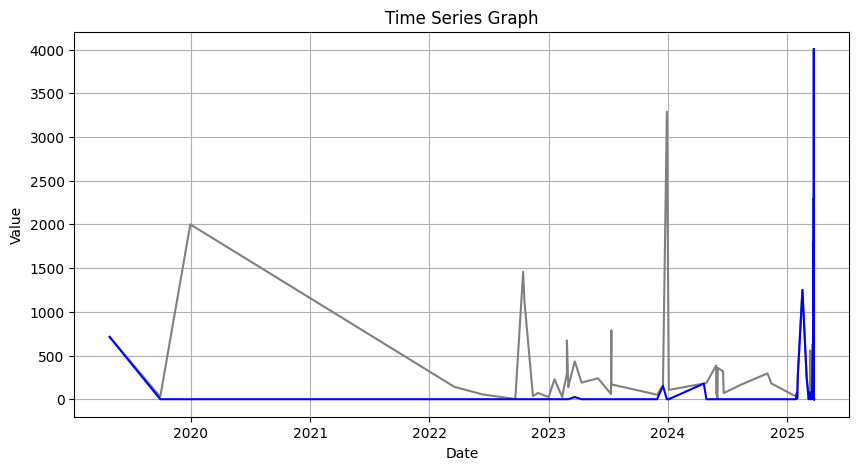

In [21]:
plt.figure(figsize=(10,5))

# plotting gross fraud & net fraud amount
plt.plot(df_case['reported_date'], df_case['gross_fraud_amt'], label='Gross Fraud Amount', color='grey')
plt.plot(df_case['reported_date'], df_case['net_fraud_amt'], label='Net Fraud Amount', color='blue')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Graph')
plt.grid(True)
plt.show()

In [22]:
# Size of fraud transactions through time series 
df_tran = pd.read_csv('cleaned_data/cleaned_fraud_tran.csv')
cols_to_replace = ['transaction_dt']
for col in cols_to_replace:
    df_tran[col] = pd.to_datetime(df_tran[col], utc=True)

df_tran = df_tran.sort_values('transaction_dt', ascending=True)

df_tran.dtypes

current_account_nbr                 object
case_id                              int64
transaction_dt         datetime64[ns, UTC]
transaction_am                     float64
dtype: object

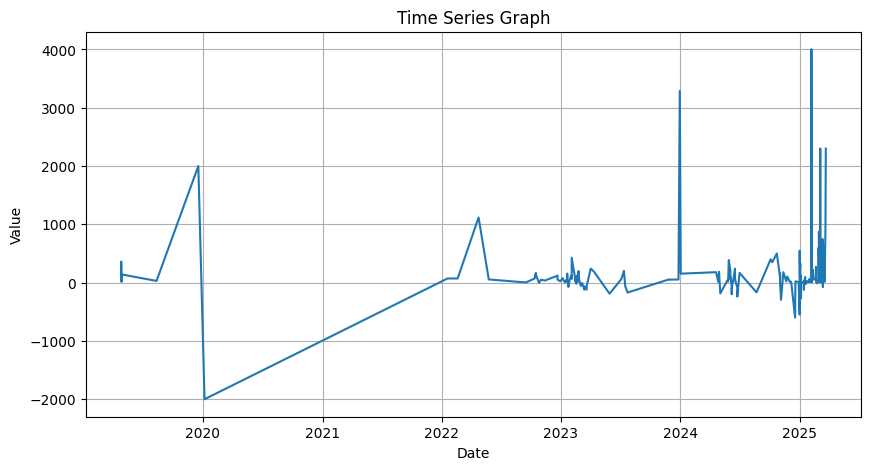

In [23]:
plt.figure(figsize=(10,5))
plt.plot(df_tran['transaction_dt'], df_tran['transaction_am']) 
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Graph')
plt.grid(True)
plt.show()

In [24]:
# Account balance over time distinction between high income & normal account
df_statements = pd.read_csv('cleaned_data/cleaned_statement_fact.csv')
cols_to_replace = ['billing_cycle_date']
for col in cols_to_replace:
    df_statements[col] = pd.to_datetime(df_statements[col], utc=True)

# Adding the is_high_income flag
df_high_income = pd.read_csv('cleaned_data/cleaned_account_dim.csv')
df_merged = df_statements.merge(df_high_income[['current_account_nbr', 'is_high_income']], on='current_account_nbr', how='left')
print(df_merged.shape)

# Sort by timestamp
df_merged.sort_values('billing_cycle_date', ascending=True, inplace=True)
df_merged.set_index('billing_cycle_date', inplace=True)
df_one = df_merged[df_merged['current_account_nbr'] == '3bi2SO6Nrv30eCpu']
print(df_one)


# Sample 1000 entries from each group for better visualization
df_high_sample = df_merged[df_merged['is_high_income'] == 1]
df_non_high_sample = df_merged[df_merged['is_high_income'] == 0]

df_high_grouped = df_high_sample.groupby('billing_cycle_date').agg({'prev_balance': 'mean'})
df_non_high_grouped = df_non_high_sample.groupby('billing_cycle_date').agg({'prev_balance': 'mean'})

(658228, 10)
                          current_account_nbr payment_hist_1_12_mths  \
billing_cycle_date                                                     
2021-09-02 00:00:00+00:00    3bi2SO6Nrv30eCpu           QQQQQQQQQQQQ   
2021-10-01 00:00:00+00:00    3bi2SO6Nrv30eCpu           QQQQQQQQQQQQ   
2021-11-02 00:00:00+00:00    3bi2SO6Nrv30eCpu           QQQQQQQQQQQQ   
2021-12-02 00:00:00+00:00    3bi2SO6Nrv30eCpu           QQQQQQQQQQQQ   
2022-01-02 00:00:00+00:00    3bi2SO6Nrv30eCpu           QQQQQQQQQQQQ   
2022-02-02 00:00:00+00:00    3bi2SO6Nrv30eCpu           QQQQQQQQQQQQ   
2022-03-02 00:00:00+00:00    3bi2SO6Nrv30eCpu           BQQQQQQQQQQQ   
2022-04-01 00:00:00+00:00    3bi2SO6Nrv30eCpu           QBQQQQQQQQQQ   
2022-05-02 00:00:00+00:00    3bi2SO6Nrv30eCpu           QQBQQQQQQQQQ   
2022-06-02 00:00:00+00:00    3bi2SO6Nrv30eCpu           QQQBQQQQQQQQ   
2022-07-01 00:00:00+00:00    3bi2SO6Nrv30eCpu           QQQQBQQQQQQQ   
2022-08-02 00:00:00+00:00    3bi2SO6Nrv30eCpu      

In [ ]:
# Adding the fraud
df_high_income = pd.read_csv('cleaned_data/cleaned_account_dim.csv')
df_merged = df_statements.merge(df_high_income[['current_account_nbr', 'is_high_income']], on='current_account_nbr', how='left')
df_master = pd.read_csv('exploratory_data_analysis/master_user_dataset_with_predictions.csv')
df_merged = df_statements.merge(df_high_income[['current_account_nbr', 'has_fraud', ]], on='current_account_nbr', how='left')
print(df_merged.shape)

# Sort by timestamp
df_merged.sort_values('billing_cycle_date', ascending=True, inplace=True)
df_merged.set_index('billing_cycle_date', inplace=True)
df_one = df_merged[df_merged['current_account_nbr'] == '3bi2SO6Nrv30eCpu']
print(df_one)


# Sample 1000 entries from each group for better visualization
df_high_sample = df_merged[df_merged['is_high_income'] == 1]
df_non_high_sample = df_merged[df_merged['is_high_income'] == 0]

df_high_grouped = df_high_sample.groupby('billing_cycle_date').agg({'prev_balance': 'mean'})
df_non_high_grouped = df_non_high_sample.groupby('billing_cycle_date').agg({'prev_balance': 'mean'})

(658228, 10)
                          current_account_nbr payment_hist_1_12_mths  \
billing_cycle_date                                                     
2021-09-02 00:00:00+00:00    3bi2SO6Nrv30eCpu           QQQQQQQQQQQQ   
2021-10-01 00:00:00+00:00    3bi2SO6Nrv30eCpu           QQQQQQQQQQQQ   
2021-11-02 00:00:00+00:00    3bi2SO6Nrv30eCpu           QQQQQQQQQQQQ   
2021-12-02 00:00:00+00:00    3bi2SO6Nrv30eCpu           QQQQQQQQQQQQ   
2022-01-02 00:00:00+00:00    3bi2SO6Nrv30eCpu           QQQQQQQQQQQQ   
2022-02-02 00:00:00+00:00    3bi2SO6Nrv30eCpu           QQQQQQQQQQQQ   
2022-03-02 00:00:00+00:00    3bi2SO6Nrv30eCpu           BQQQQQQQQQQQ   
2022-04-01 00:00:00+00:00    3bi2SO6Nrv30eCpu           QBQQQQQQQQQQ   
2022-05-02 00:00:00+00:00    3bi2SO6Nrv30eCpu           QQBQQQQQQQQQ   
2022-06-02 00:00:00+00:00    3bi2SO6Nrv30eCpu           QQQBQQQQQQQQ   
2022-07-01 00:00:00+00:00    3bi2SO6Nrv30eCpu           QQQQBQQQQQQQ   
2022-08-02 00:00:00+00:00    3bi2SO6Nrv30eCpu      

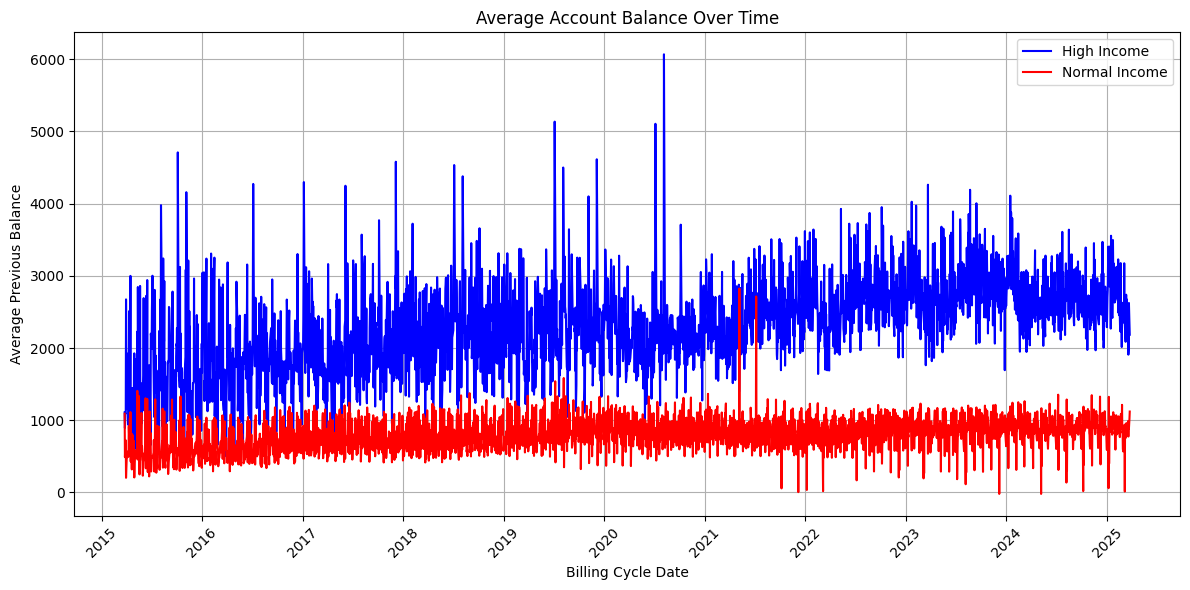

<Figure size 640x480 with 0 Axes>

In [26]:
plt.figure(figsize=(12, 6))

plt.plot(df_high_grouped.index, df_high_grouped['prev_balance'], label='High Income', color='blue')
plt.plot(df_non_high_grouped.index, df_non_high_grouped['prev_balance'], label='Normal Income', color='red')

plt.xlabel('Billing Cycle Date')
plt.ylabel('Average Previous Balance')
plt.title('Average Account Balance Over Time')

plt.grid(True)
plt.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.savefig('./visualizations/account_balance_high_normal')

KeyboardInterrupt: 

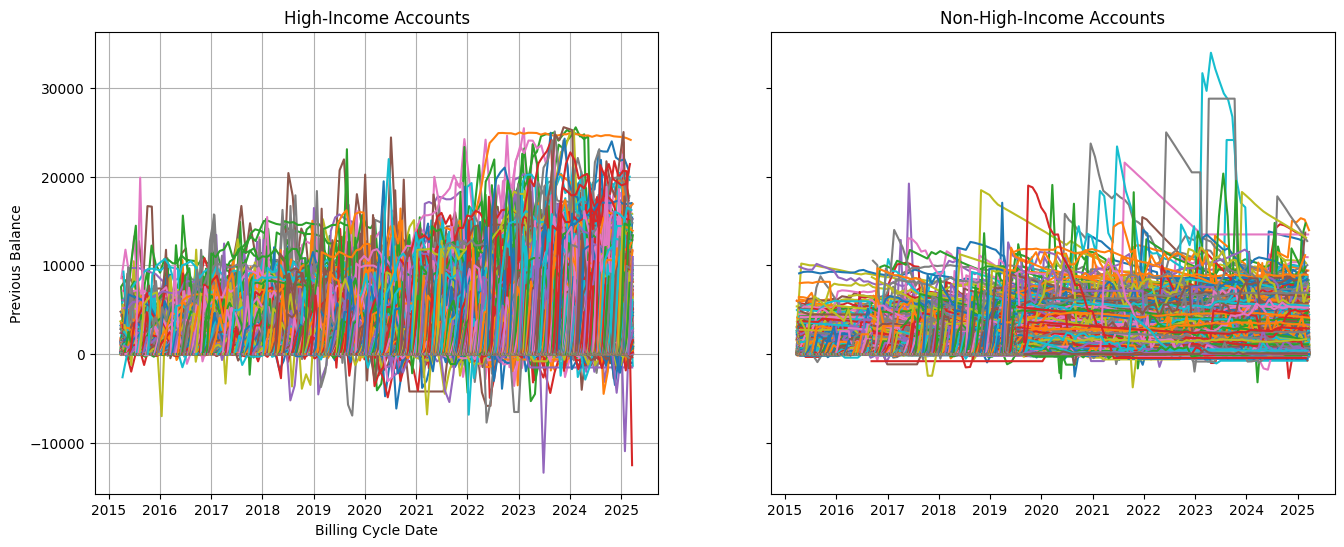

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

colors = sns.color_palette("tab10", 10)

axes[0].set_title("High-Income Accounts")
for i, account in enumerate(df_high_sample['current_account_nbr'].unique()):
    account_data = df_high_sample[df_high_sample['current_account_nbr'] == account]
    axes[0].plot(account_data.index, account_data['prev_balance'], label=f'Account {account}', color=colors[i % len(colors)])

axes[0].set_xlabel("Billing Cycle Date")
axes[0].set_ylabel("Previous Balance")
axes[0].grid(True)

axes[1].set_title("Non-High-Income Accounts")
for i, account in enumerate(df_non_high_sample['current_account_nbr'].unique()):
    account_data = df_non_high_sample[df_non_high_sample['current_account_nbr'] == account]
    axes[1].plot(account_data.index, account_data['prev_balance'], label=f'Account {account}', color=colors[i % len(colors)])

axes[1].set_xlabel("Billing Cycle Date")
axes[1].grid(True)

plt.tight_layout()
plt.show()